In [1]:
import os.path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
backend_format = "retina"  # @param ["retina", ""]
%config InlineBackend.figure_format = backend_format

sns.set_context("notebook")
sns.set_style("ticks")

plt.rcParams['ytick.right'] = True
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

In [3]:
experiments = [
    dict(
        agent_id='dqn',
        agent_name='DQN',
        color='grey'),
    dict(
        agent_id='double_q',
        agent_name='Double DQN',
        color='purple'),
#     dict(
#         agent_id='prioritized',
#         agent_name='Prioritized DQN',
#         color='blue'),
#     dict(
#         agent_id='c51',
#         agent_name='C51',
#         color='orange'),
#     dict(
#         agent_id='qrdqn',
#         agent_name='QR-DQN',
#         color='red'),
#     dict(
#         agent_id='rainbow',
#         agent_name='Rainbow',
#         color='black'),
#     dict(
#         agent_id='iqn',
#         agent_name='IQN',
#         color='green'),
]

In [4]:
def load_experiment_data_from_results_csv_dir(experiment_details, results_dir):
    df_exps = []
    for ed in experiment_details:
        csv_file = os.path.join(results_dir, ed['agent_id'] + '.csv')
        with open(csv_file, 'r') as f:
            # 将第一列(iteration)作为索引列 -> index_col=0
            df = pd.read_csv(f, index_col=0)
        df = df.assign(agent_id=ed['agent_id'], agent_name=ed['agent_name'])
        df_exps.append(df)

    # 删除旧的索引列(iteration)，并为其排上默认索引列
    df_exp = pd.concat(df_exps, sort=True).reset_index(drop=True)
    return df_exp

In [5]:
df_exp_raw = load_experiment_data_from_results_csv_dir(experiments, 'D:/xuyanjiao/exp/results/')

In [6]:
def moving_average(values, window_size):
    # numpy.convolve uses zero for initial missing values, so is not suitable.
    numerator = np.nancumsum(values)
    # The sum of the last window_size values.
    numerator[window_size:] = numerator[window_size:] - numerator[:-window_size]
    denominator = np.ones(len(values)) * window_size
    denominator[:window_size] = np.arange(1, window_size + 1)
    smoothed = numerator / denominator
    assert values.shape == smoothed.shape
    return smoothed


def smooth(df, smoothing_window, index_columns, columns):
    dfg = df.groupby(index_columns)
    for col in columns:
        df[col] = dfg[col].transform(
            lambda s: moving_average(s.values, smoothing_window))
    return df


def add_columns(df):
    df['frame_ten_thousand'] = df['frame'] // int(1e4)
    return df


def smooth_dataframe(df):
    return smooth(
      df,
      smoothing_window=10,
      index_columns=['agent_id'],
      columns=[
          'train_frame_rate',
          'normalized_return',
          'eval_episode_return',
      ])

In [7]:
# pipe == 系列函数处理
df_exp = df_exp_raw.pipe(add_columns).pipe(smooth_dataframe)
df = df_exp.sort_values(by=['agent_id', 'frame'])

In [8]:
def make_agent_hue_kws(experiments):
    pairs = [(exp['agent_name'], exp['color']) for exp in experiments]
    agent_names, colors = zip(*pairs)
    hue_kws = dict(color=colors)
    return list(agent_names), hue_kws

In [27]:
def plot_summary(df, agent_names, hue_kws):
    df = df.query('agent_name == %s' % agent_names)
    # 游戏agent相对于人类玩家的水平(人类水平100%)
    df['normalized_return_percent'] = df['normalized_return'] * 100

    fig, ax = plt.subplots(figsize=(9, 6))
    sns.lineplot(
        x=df['frame_ten_thousand'],
        y=df['normalized_return_percent'],
        hue=df['agent_name'],
        estimator=np.median,
        ci=100,
        alpha=0.5,
        linewidth=3,
        hue_order=agent_names,
        palette=hue_kws['color'],
        legend='brief',
        ax=ax,
    )
    ax.set_title('')
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.set_xlabel('Frame (1e4)')
    ax.set_ylabel('Median human-normalized score')
    ax.set(ylim=(0, 50))

    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())

    # Grab generated legend and remove label 'agent'.
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        loc='upper left',
        handles=handles[0:],
        labels=labels[0:],
        frameon=False,
    )

    fig.tight_layout()
    # 加上return会出现2个一样的图(?)
#     return fig

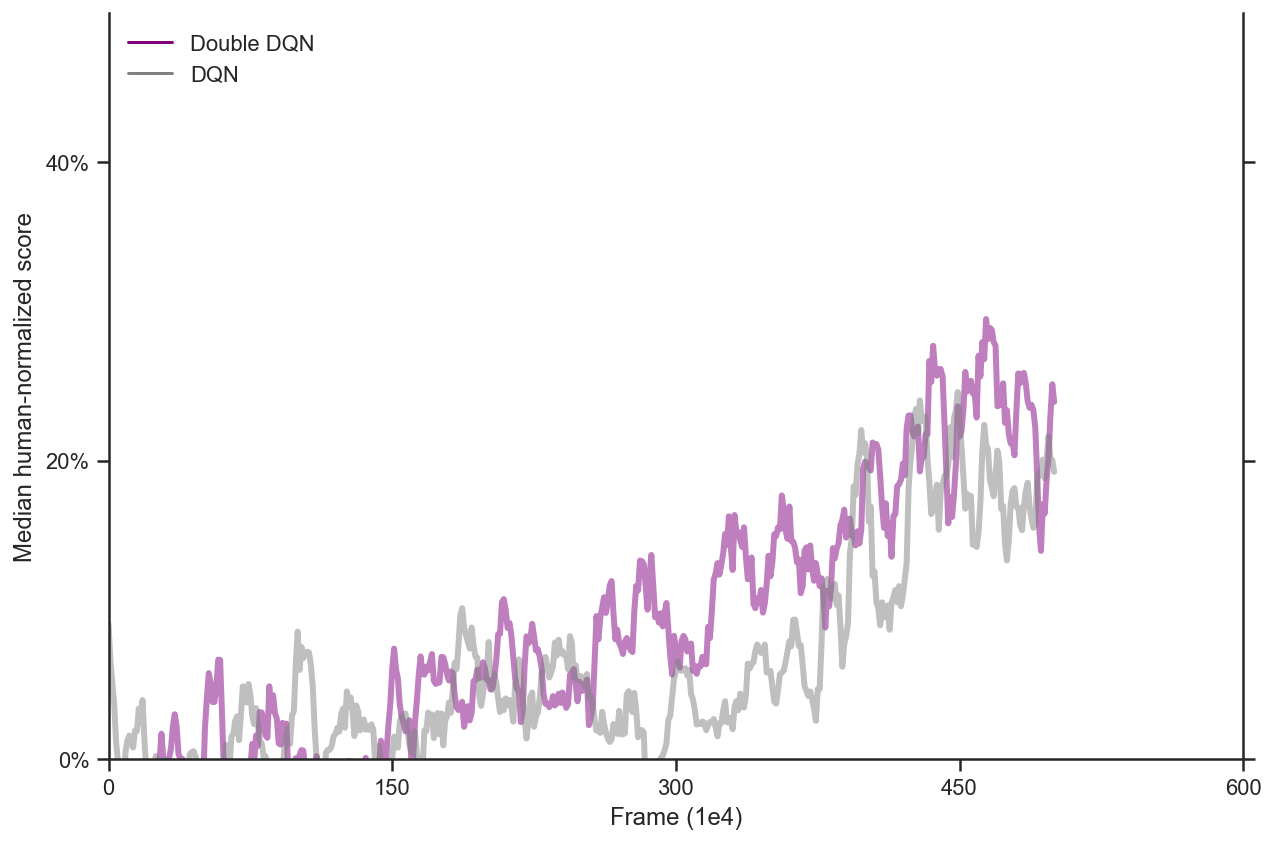

In [28]:
agent_id_to_experiment = {e['agent_id']: e for e in experiments}
agent_id_ordered_by_performance = [
#     'rainbow',
#     'iqn',
#     'qrdqn',
#     'c51',
#     'prioritized',
    'double_q',
    'dqn',
]
experiments_ordered_by_performance = [
    agent_id_to_experiment[agent_id]
    for agent_id in agent_id_ordered_by_performance
]
plot_summary(df, *make_agent_hue_kws(experiments_ordered_by_performance))